# Boston House Pricing 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from src.visualize import plot_loss
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.4.1


## Dataset
Obtain the dataset from the keras package. The API splits the data and renders tuples for training and test sets.

In [2]:
# Create column names
features = ["Crime", "Zoned", "Industrial", "Charles", "NOX", "Rooms", "Age", "Distance", "Radial", "Tax", "PTRatio", "Blacks", "LowerStatus"]
target = ['MedianValue']

In [3]:
# Obtain Boston Housing Data and split into training and test sets
boston = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)
(x_train, y_train), (x_test, y_test) = boston


## Data Inspection
We'll create a dataframe containing the training data with columns for visualization

In [4]:
df = pd.DataFrame(x_train, columns=features)
df.head()

,Crime,Zoned,Industrial,Charles,NOX,Rooms,Age,Distance,Radial,Tax,PTRatio,Blacks,LowerStatus
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Crime,404.0,3.745111,9.240734,0.00632,0.081437,0.26888,3.674808,88.9762
Zoned,404.0,11.480198,23.767711,0.00000,0.000000,0.00000,12.500000,100.0000
Industrial,404.0,11.104431,6.811308,0.46000,5.130000,9.69000,18.100000,27.7400
Charles,404.0,0.061881,0.241238,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,404.0,0.557356,0.117293,0.38500,0.453000,0.53800,0.631000,0.8710
Rooms,404.0,6.267082,0.709788,3.56100,5.874750,6.19850,6.609000,8.7250
Age,404.0,69.010644,27.940665,2.90000,45.475000,78.50000,94.100000,100.0000
Distance,404.0,3.740271,2.030215,1.12960,2.077100,3.14230,5.118000,10.7103
Radial,404.0,9.440594,8.698360,1.00000,4.000000,5.00000,24.000000,24.0000
Tax,404.0,405.898515,166.374543,188.00000,279.000000,330.00000,666.000000,711.0000


## Modeling
### Base Model

In [6]:
# Create a normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(x_train)

# Create a model that includes the normalization layer
model_0 = tf.keras.Sequential([
    normalizer,    
    tf.keras.layers.Dense(units=1)    
])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense (Dense)                (None, 1)                 14        
Total params: 41
Trainable params: 14
Non-trainable params: 27
_________________________________________________________________


2022-07-21 04:03:32.486311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-21 04:03:32.486659: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 04:03:32.492863: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
%%time
# Compile the model to track mean squared error using the Adam optimizer with learning rate 0.1
model_0.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_0_history = model_0.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    verbose=0, # Suppress logging
    )

2022-07-21 04:03:32.802799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-21 04:03:32.803284: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2659995000 Hz


CPU times: user 2min 19s, sys: 6min 42s, total: 9min 2s
Wall time: 24.3 s


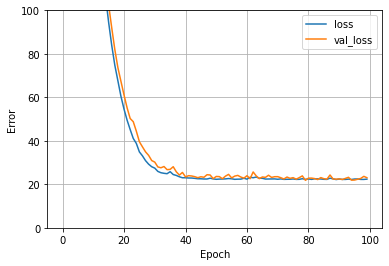

In [12]:
plot_loss(model_0_history,ylim=[0,100])

In [9]:
# Save test results
test_results = {}
test_results['model_0'] = model_0.evaluate(
    x_train,
    y_train, verbose=0
)

### Model 1: Deep Neural Network

In [13]:
model_1 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1),
])
model_1.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_1_history = model_1.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    verbose=0, # Suppress logging
    )
test_results['model_1'] = model_1.evaluate(
    x_train,
    y_train, verbose=0
)    

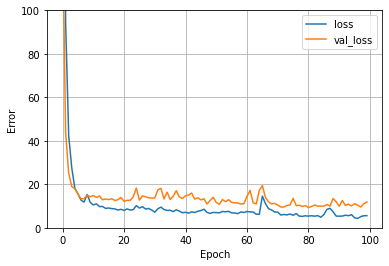

In [14]:
plot_loss(model_1_history,ylim=[0,100])

### Model 2: Deep Neural Network

In [17]:
model_2 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1),
])
model_2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_2_history = model_2.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    verbose=0, # Suppress logging
    )
test_results['model_2'] = model_2.evaluate(
    x_train,
    y_train, verbose=0
)    

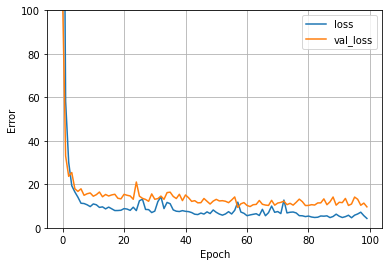

In [18]:
plot_loss(model_2_history,ylim=[0,100])

In [19]:
pd.DataFrame(test_results, index=['Mean Squared Error']).T

,Mean Squared Error
model_0,22.379442
model_1,6.198429
model_2,5.142210
